# Speech Emotion Recognition

# Libraries

In [144]:
import os
from IPython.display import Audio
import librosa
import librosa.display as disp
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Implimentation

In [72]:
path = 'emotions\\'
def load_data(path):
    f_emotions=[]
    f_pathes=[]
    folders = os.listdir(path)
    for folder in folders:
        fiels = os.listdir(path + folder)
        for file in fiels:
            step = file.split('.')[0]
            step = (step.split('-')[2]) #because the emotions are there in this column
            f_emotions.append(int(step))
            f_pathes.append(path + folder + os.sep + file)
    return (f_emotions,f_pathes)
emotions,pathes=load_data(path)


In [71]:
def get_emotion(number):
    info={1 : 'neutral',
          2 : 'calm',
          3 : 'happy',
          4 : 'sad',
          5 : 'angry',
          6 : 'fearful',
          7 : 'disgust',
          8 : 'surprised'}
    return info[number]

In [ ]:
def read_audio(path):
    data , sample_rate =librosa.load(path,duration=2.4,offset=0.6)
    return data,sample_rate

def draw_wave(path,data,sr):
    plt.figure(figsize=(10,4))
    #data , sr =librosa.load(path)
    plt.title('Audio Wave :: '+ path,size=17)
    disp.waveshow(data,sr=sr)
    plt.show()
def draw_spectogram(path,data,sr):
    plt.figure(figsize=(10,4))
    #data , sr =librosa.load(path)
    x= librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.title('Spectogram for Wave :: '+ path,size=17)
    disp.specshow(xdb,sr=sr,x_axis='time',y_axis='log')
    plt.show()
def add_noise(data,sr):
    noise = 0.035*np.random.uniform()*np.amax(data)
    data += noise * np.random.normal(size=data.shape[0])
    return data,sr
def shift(data,sr):
    shift_range = int(np.random.uniform(low=5,high=5)*100)
    shifted= np.roll(data,shift_range)
    return shifted,sr
def pitch(data,sr,factor=0.7):
    pitched = librosa.effects.pitch_shift(y=data,sr=sr,n_steps=factor)

    return pitched,sr
def stretch(data,sr,rate=0.85):
    stretched = librosa.effects.time_stretch(y=data,rate=rate)
    return stretched,sr

### feature extraction MFCCs:

def feature_extraction(data,sr):
    mfcc = librosa.feature.mfcc(y=data,sr=sr)
    return mfcc
def processing_audio(data,sr,options):
     func = random.choice(options)
     if func == 'Standard':
         processed = data
     else:
         processed,_ =func(data,sr)
     return processed

20
calm


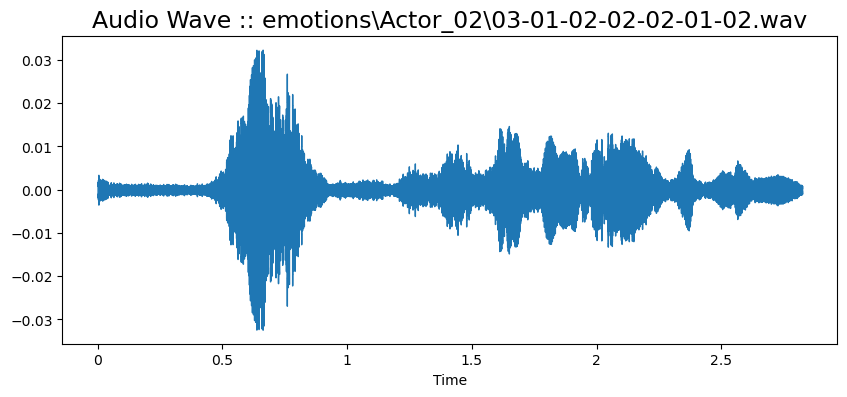

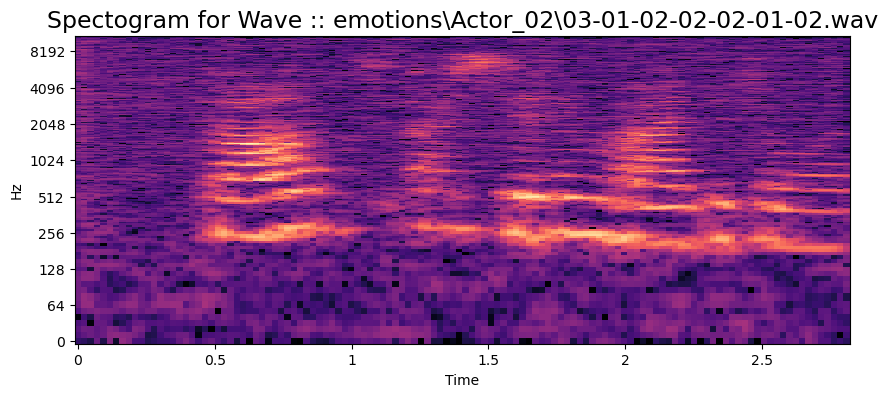

In [141]:
def get_feature(path):
    data, sample_rate = read_audio(path)
    funcs = ['Standard', add_noise, pitch]
    features = []

    for _ in range(3):
        func1_data = processing_audio(data, sample_rate, funcs)
        func2_data = processing_audio(func1_data, sample_rate, funcs)
        feature = feature_extraction(func2_data, sample_rate)
        if feature.shape == (20, 104):
            features.append(feature)

    return features



def display(number):
    data,sample_rate=read_audio(pathes[number])
    mfcc_feature=feature_extraction(data,sample_rate)
    print(len(mfcc_feature))
    print(get_emotion(emotions[number]))
    data,sample_rate = add_noise(data,sample_rate)

    #data,sample_rate = shift(data,sample_rate)
    data,sample_rate = stretch(data,sample_rate)
    data,sample_rate = pitch(data,sample_rate)
    draw_wave(pathes[number],data,sample_rate)
    draw_spectogram(pathes[number],data,sample_rate)
    return data,sample_rate

d,sr=display(70)
Audio(data=d,rate=sr)


In [137]:
x=[]
y=[]
for indx in range(len(pathes)):
    value = get_feature(pathes[indx])
    if value != []:
        for item in value:
            x.append(item)
            y.append(np.eye(8)[emotions[indx]-1])
        

In [140]:
print(len(x))
print(len(y))

4314
4314


x shape: (4314, 2080)
New x shape: (4314, 2080)
Training...
Test Accuracy: 90.27%


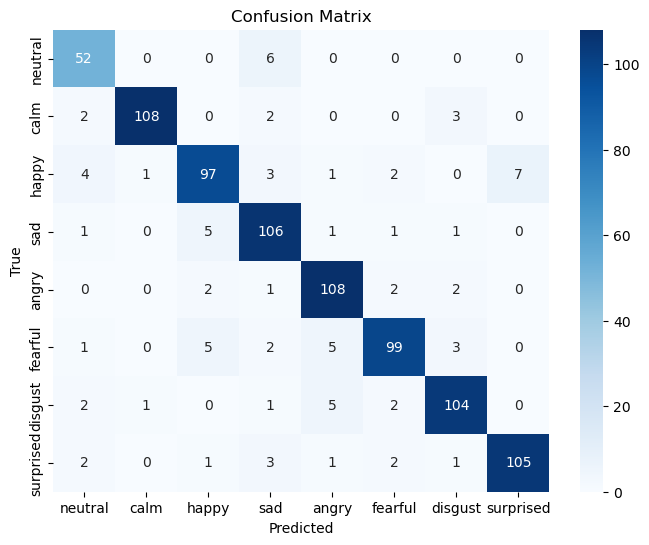

['trained_model.pkl']

In [ ]:

# Convert x and y to numpy arrays
x = np.array(x)
y = np.array(y)

# Print the shape of x to understand if it's 2D or 3D
print(f"x shape: {x.shape}")

# If x is 2D, we just need to reshape it accordingly
if len(x.shape) == 2:
    x = x.reshape(x.shape[0], -1)  # Flatten the features into 1D
else:
    nsamples, nx, ny = x.shape
    x = x.reshape((nsamples, nx * ny))  # Flatten the 3D array into 2D

print(f"New x shape: {x.shape}")

# Convert y from One-Hot Encoding to Label (integer)
y_labels = np.argmax(y, axis=1)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y_labels, test_size=0.2, random_state=42, stratify=y_labels,shuffle=True)

# Create the SVM model with a linear kernel
model = SVC(kernel='linear', probability=True)

# Train the model
print("Training...")
model.fit(x_train, y_train)

# Evaluate the model
y_pred = model.predict(x_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[get_emotion(i+1) for i in range(8)], yticklabels=[get_emotion(i+1) for i in range(8)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

import joblib

model.fit(x_train, y_train)

# save model
joblib.dump(model, 'trained_model.pkl')  # تأكد من تحديد المسار الصحيح

